In [34]:
# ===============================
# Project paths (RUN FIRST)
# ===============================

from pathlib import Path

PROJECT_ROOT = Path("..").resolve()

DATA_DIR   = PROJECT_ROOT / "data"
ENROL_DIR  = DATA_DIR / "enrolment"
DEMO_DIR   = DATA_DIR / "demographic"
BIO_DIR    = DATA_DIR / "biometric"
SHAPE_DIR  = DATA_DIR / "shapefile"
OUTPUT_DIR = PROJECT_ROOT / "outputs"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SHAPE_DIR:", SHAPE_DIR)


PROJECT_ROOT: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress
SHAPE_DIR: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress\data\shapefile


In [35]:
from pathlib import Path
import pandas as pd

# Project root (assuming notebook is in /notebooks)
PROJECT_ROOT = Path("..").resolve()

DATA_DIR = PROJECT_ROOT / "data"
ENROL_DIR = DATA_DIR / "enrolment"
DEMO_DIR  = DATA_DIR / "demographic"
BIO_DIR   = DATA_DIR / "biometric"

def read_concat(path):
    files = sorted(path.glob("*.csv"))
    print(f"\nReading from: {path}")
    print("Files found:", len(files))
    for f in files:
        print(" -", f.name)
    return pd.concat(
        [pd.read_csv(f, low_memory=False) for f in files],
        ignore_index=True
    )

enrol_full = read_concat(ENROL_DIR)
demo_full  = read_concat(DEMO_DIR)
bio_full   = read_concat(BIO_DIR)

# Standardize column names
for df in (enrol_full, demo_full, bio_full):
    df.columns = [c.strip() for c in df.columns]

print(
    "Shapes:",
    "enrol_full", enrol_full.shape,
    "demo_full", demo_full.shape,
    "bio_full", bio_full.shape
)



Reading from: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress\data\enrolment
Files found: 3
 - api_data_aadhar_enrolment_0_500000.csv
 - api_data_aadhar_enrolment_1000000_1006029.csv
 - api_data_aadhar_enrolment_500000_1000000.csv

Reading from: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress\data\demographic
Files found: 5
 - api_data_aadhar_demographic_0_500000.csv
 - api_data_aadhar_demographic_1000000_1500000.csv
 - api_data_aadhar_demographic_1500000_2000000.csv
 - api_data_aadhar_demographic_2000000_2071700.csv
 - api_data_aadhar_demographic_500000_1000000.csv

Reading from: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress\data\biometric
Files found: 4
 - api_data_aadhar_biometric_0_500000.csv
 - api_data_aadhar_biometric_1000000_1500000.csv
 - api_data_aadhar_biometric_1500000_1861108.csv
 - api_data_aadhar_biometric_500000_1000000.csv
Shapes: enrol_full (1006029, 7) demo_full (2071700, 6) bio_full (1861108, 6)


In [36]:
def read_and_concat_csv(folder: Path, label: str) -> pd.DataFrame:
    if not folder.exists():
        raise FileNotFoundError(f"{label} folder not found: {folder}")

    files = sorted(folder.glob("*.csv"))

    print(f"\n[{label}] CSV files found:", len(files))
    for f in files:
        print(" -", f.name)

    if len(files) == 0:
        raise ValueError(f"No CSV files found in {folder}")

    df = pd.concat(
        [pd.read_csv(f, low_memory=False) for f in files],
        ignore_index=True
    )

    # Clean column names
    df.columns = [c.strip() for c in df.columns]

    print(f"[{label}] Loaded shape:", df.shape)
    return df


In [37]:
# ===============================
# Load UIDAI datasets
# ===============================

enrolment_full   = read_and_concat_csv(ENROL_DIR, "ENROLMENT")
demographic_full = read_and_concat_csv(DEMO_DIR,  "DEMOGRAPHIC")
biometric_full   = read_and_concat_csv(BIO_DIR,   "BIOMETRIC")



[ENROLMENT] CSV files found: 3
 - api_data_aadhar_enrolment_0_500000.csv
 - api_data_aadhar_enrolment_1000000_1006029.csv
 - api_data_aadhar_enrolment_500000_1000000.csv
[ENROLMENT] Loaded shape: (1006029, 7)

[DEMOGRAPHIC] CSV files found: 5
 - api_data_aadhar_demographic_0_500000.csv
 - api_data_aadhar_demographic_1000000_1500000.csv
 - api_data_aadhar_demographic_1500000_2000000.csv
 - api_data_aadhar_demographic_2000000_2071700.csv
 - api_data_aadhar_demographic_500000_1000000.csv
[DEMOGRAPHIC] Loaded shape: (2071700, 6)

[BIOMETRIC] CSV files found: 4
 - api_data_aadhar_biometric_0_500000.csv
 - api_data_aadhar_biometric_1000000_1500000.csv
 - api_data_aadhar_biometric_1500000_1861108.csv
 - api_data_aadhar_biometric_500000_1000000.csv
[BIOMETRIC] Loaded shape: (1861108, 6)


In [38]:
# ===============================
# HARD DATE NORMALIZATION (DO NOT MOVE)
# ===============================

def normalize_dates(df, name):
    if "date" not in df.columns:
        raise KeyError(f"'date' column missing in {name}")

    df["date"] = (
        df["date"]
        .astype(str)
        .str.strip()
        .pipe(pd.to_datetime, errors="coerce", dayfirst=True)
    )

    print(
        f"{name}: dtype={df['date'].dtype}, "
        f"invalid_dates={df['date'].isna().sum()}"
    )

    return df.dropna(subset=["date"])


enrolment_full   = normalize_dates(enrolment_full, "enrolment")
demographic_full = normalize_dates(demographic_full, "demographic")
biometric_full   = normalize_dates(biometric_full, "biometric")


enrolment: dtype=datetime64[ns], invalid_dates=0
demographic: dtype=datetime64[ns], invalid_dates=0
biometric: dtype=datetime64[ns], invalid_dates=0


In [39]:
START_DATE = "2025-04-01"
END_DATE   = "2025-10-31"

start = pd.to_datetime(START_DATE)
end   = pd.to_datetime(END_DATE)

enrol_time = enrolment_full[(enrolment_full["date"] >= start) & (enrolment_full["date"] <= end)]
demo_time  = demographic_full[(demographic_full["date"] >= start) & (demographic_full["date"] <= end)]
bio_time   = biometric_full[(biometric_full["date"] >= start) & (biometric_full["date"] <= end)]

print("After time filter:")
print("Enrolment:", enrol_time.shape)
print("Demographic:", demo_time.shape)
print("Biometric:", bio_time.shape)


After time filter:
Enrolment: (571104, 7)
Demographic: (828847, 6)
Biometric: (836311, 6)


In [40]:
def get_reporting_dates(df):
    return set(df["date"].dropna().unique())

common_dates = (
    get_reporting_dates(enrol_time)
    & get_reporting_dates(demo_time)
    & get_reporting_dates(bio_time)
)

print("Common reporting days:", len(common_dates))
print(sorted(list(common_dates))[:5])


Common reporting days: 42
[Timestamp('2025-04-01 00:00:00'), Timestamp('2025-05-01 00:00:00'), Timestamp('2025-06-01 00:00:00'), Timestamp('2025-07-01 00:00:00'), Timestamp('2025-09-01 00:00:00')]


In [41]:
enrol_geo = enrol_time[enrol_time["date"].isin(common_dates)]
demo_geo  = demo_time[demo_time["date"].isin(common_dates)]
bio_geo   = bio_time[bio_time["date"].isin(common_dates)]

print("Geo-filtered rows:")
print("Enrolment:", enrol_geo.shape)
print("Demographic:", demo_geo.shape)
print("Biometric:", bio_geo.shape)


Geo-filtered rows:
Enrolment: (489003, 7)
Demographic: (828847, 6)
Biometric: (836311, 6)


In [42]:
def aggregate_by_district(df):
    age_cols = [c for c in df.columns if "age" in c.lower()]
    
    agg = (
        df
        .groupby("district")[age_cols]
        .sum()
        .sum(axis=1)
        .reset_index(name="total_activity")
    )
    return agg


# aggregate
enrol_dist = aggregate_by_district(enrol_geo).rename(
    columns={"total_activity": "enrolment_total"}
)

demo_dist = aggregate_by_district(demo_geo).rename(
    columns={"total_activity": "demographic_total"}
)

bio_dist = aggregate_by_district(bio_geo).rename(
    columns={"total_activity": "biometric_total"}
)

print("District counts:")
print("Enrolment districts:", enrol_dist.shape[0])
print("Demographic districts:", demo_dist.shape[0])
print("Biometric districts:", bio_dist.shape[0])


District counts:
Enrolment districts: 969
Demographic districts: 948
Biometric districts: 953


In [43]:
geo_compare = (
    enrol_dist
    .merge(demo_dist, on="district", how="inner")
    .merge(bio_dist, on="district", how="inner")
)

print("Districts with complete data:", geo_compare.shape[0])
geo_compare.head()


Districts with complete data: 929


,district,enrolment_total,demographic_total,biometric_total
0,ANUGUL,4,63,161
1,Adilabad,2632,31851,85938
2,Agar Malwa,840,3870,11309
3,Agra,20008,58478,157876
4,Ahmadabad,6121,2834,9852


APPLYING THRESHOLD

In [44]:
geo_filtered = geo_compare[geo_compare["enrolment_total"] >= 100]

print("Districts after enrolment threshold:", geo_filtered.shape[0])


Districts after enrolment threshold: 806


In [45]:
geo_filtered["demo_to_enrol_ratio"] = (
    geo_filtered["demographic_total"] / geo_filtered["enrolment_total"]
)

geo_filtered["bio_to_enrol_ratio"] = (
    geo_filtered["biometric_total"] / geo_filtered["enrolment_total"]
)


C:\Users\amogh\AppData\Local\Temp\ipykernel_3368\3320341369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_filtered["demo_to_enrol_ratio"] = (
C:\Users\amogh\AppData\Local\Temp\ipykernel_3368\3320341369.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_filtered["bio_to_enrol_ratio"] = (


In [46]:
top_demo_stress = geo_filtered.sort_values(
    "demo_to_enrol_ratio", ascending=False
).head(5)

top_demo_stress


,district,enrolment_total,demographic_total,biometric_total,demo_to_enrol_ratio,bio_to_enrol_ratio
547,Mohla-Manpur-Ambagarh Chouki,127,9895,3914,77.913386,30.818898
506,Mahasamund,1718,103719,64890,60.371944,37.770664
915,Y. S. R,358,17727,5900,49.516760,16.480447
690,Rajnandgaon,1715,84779,97897,49.433819,57.082799
35,Annamayya,431,21105,6841,48.967517,15.872390


In [47]:
top_bio_stress = geo_filtered.sort_values(
    "bio_to_enrol_ratio", ascending=False
).head(5)

top_bio_stress


,district,enrolment_total,demographic_total,biometric_total,demo_to_enrol_ratio,bio_to_enrol_ratio
190,Dantewada,113,599,13822,5.300885,122.318584
108,Bhandara,750,11607,65323,15.476000,87.097333
840,Thoubal,451,17635,36727,39.101996,81.434590
894,Wardha,909,7644,73939,8.409241,81.341034
185,Dakshin Bastar Dantewada,233,1481,18730,6.356223,80.386266


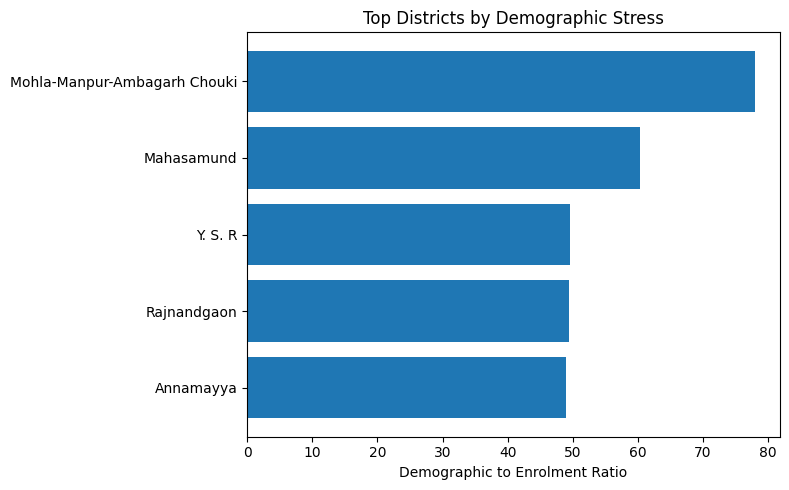

In [48]:
import matplotlib.pyplot as plt

top_demo = top_demo_stress.sort_values("demo_to_enrol_ratio")

plt.figure(figsize=(8,5))
plt.barh(
    top_demo["district"],
    top_demo["demo_to_enrol_ratio"]
)
plt.xlabel("Demographic to Enrolment Ratio")
plt.title("Top Districts by Demographic Stress")
plt.tight_layout()
plt.show()


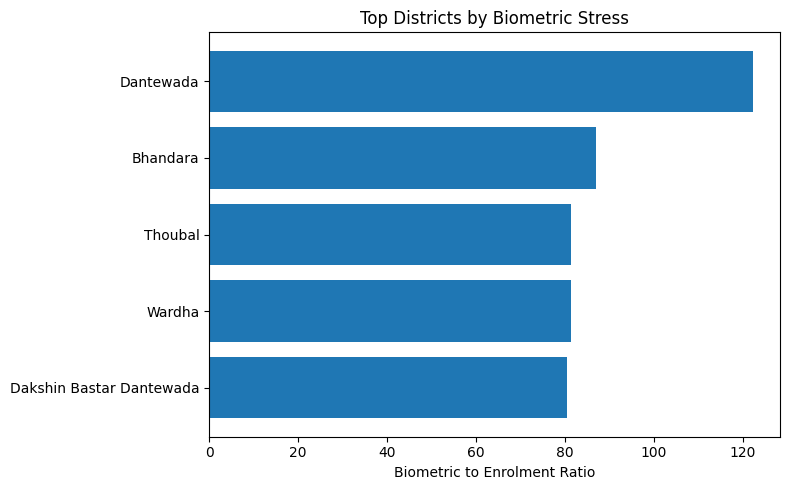

In [49]:
top_bio = top_bio_stress.sort_values("bio_to_enrol_ratio")

plt.figure(figsize=(8,5))
plt.barh(
    top_bio["district"],
    top_bio["bio_to_enrol_ratio"]
)
plt.xlabel("Biometric to Enrolment Ratio")
plt.title("Top Districts by Biometric Stress")
plt.tight_layout()
plt.show()


# GeographicStress.ipynb
**Goal:** Build a robust, reproducible district-level geographic stress analysis:
- Aggregate Aadhaar enrolment/demographic/biometric across reporting snapshots
- Compute normalized stress ratios
- Detect robust spatial anomalies (MAD)
- Produce maps and drilldowns for validation


In [50]:
# Basic imports and environment checks
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Working dir:", os.getcwd())
print("Python, pandas, numpy, matplotlib imported.")


Working dir: d:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress\notebooks
Python, pandas, numpy, matplotlib imported.


In [51]:
from pathlib import Path
import pandas as pd

# Project root (assuming notebook is in /notebooks)
PROJECT_ROOT = Path("..").resolve()

DATA_DIR = PROJECT_ROOT / "data"
ENROL_DIR = DATA_DIR / "enrolment"
DEMO_DIR  = DATA_DIR / "demographic"
BIO_DIR   = DATA_DIR / "biometric"

def read_concat(path):
    files = sorted(path.glob("*.csv"))
    print(f"\nReading from: {path}")
    print("Files found:", len(files))
    for f in files:
        print(" -", f.name)
    return pd.concat(
        [pd.read_csv(f, low_memory=False) for f in files],
        ignore_index=True
    )

enrol_full = read_concat(ENROL_DIR)
demo_full  = read_concat(DEMO_DIR)
bio_full   = read_concat(BIO_DIR)

# Standardize column names
for df in (enrol_full, demo_full, bio_full):
    df.columns = [c.strip() for c in df.columns]

print(
    "Shapes:",
    "enrol_full", enrol_full.shape,
    "demo_full", demo_full.shape,
    "bio_full", bio_full.shape
)



Reading from: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress\data\enrolment
Files found: 3
 - api_data_aadhar_enrolment_0_500000.csv
 - api_data_aadhar_enrolment_1000000_1006029.csv
 - api_data_aadhar_enrolment_500000_1000000.csv

Reading from: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress\data\demographic
Files found: 5
 - api_data_aadhar_demographic_0_500000.csv
 - api_data_aadhar_demographic_1000000_1500000.csv
 - api_data_aadhar_demographic_1500000_2000000.csv
 - api_data_aadhar_demographic_2000000_2071700.csv
 - api_data_aadhar_demographic_500000_1000000.csv

Reading from: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress\data\biometric
Files found: 4
 - api_data_aadhar_biometric_0_500000.csv
 - api_data_aadhar_biometric_1000000_1500000.csv
 - api_data_aadhar_biometric_1500000_1861108.csv
 - api_data_aadhar_biometric_500000_1000000.csv
Shapes: enrol_full (1006029, 7) demo_full (2071700, 6) bio_full (1861108, 6)


In [52]:
# Convert date column to datetime (coerce errors)
for df in (enrol_full, demo_full, bio_full):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

print("Date ranges:")
print("Enrolment:", enrol_full['date'].min(), "to", enrol_full['date'].max())
print("Demographic:", demo_full['date'].min(), "to", demo_full['date'].max())
print("Biometric:", bio_full['date'].min(), "to", bio_full['date'].max())

# Quick check for null dates (should be none or very few)
print("Null dates: enrol", enrol_full['date'].isna().sum(),
      "demo", demo_full['date'].isna().sum(),
      "bio", bio_full['date'].isna().sum())


Date ranges:
Enrolment: 2025-01-04 00:00:00 to 2025-12-11 00:00:00
Demographic: 2025-01-03 00:00:00 to 2025-12-12 00:00:00
Biometric: 2025-01-03 00:00:00 to 2025-12-12 00:00:00
Null dates: enrol 682238 demo 1187968 bio 944100


In [53]:
# Use the same time window we used earlier
START_DATE = "2025-04-01"
END_DATE   = "2025-10-31"
start = pd.to_datetime(START_DATE); end = pd.to_datetime(END_DATE)

enrol_time = enrol_full[(enrol_full['date'] >= start) & (enrol_full['date'] <= end)].copy()
demo_time  = demo_full[(demo_full['date'] >= start) & (demo_full['date'] <= end)].copy()
bio_time   = bio_full[(bio_full['date'] >= start) & (bio_full['date'] <= end)].copy()

print("After time filtering shapes:")
print("Enrol:", enrol_time.shape, "Demo:", demo_time.shape, "Bio:", bio_time.shape)


After time filtering shapes:
Enrol: (176653, 7) Demo: (491165, 6) Bio: (454748, 6)


In [54]:
# Compute unique reporting dates per dataset
enrol_dates = set(enrol_time['date'].dropna().unique())
demo_dates  = set(demo_time['date'].dropna().unique())
bio_dates   = set(bio_time['date'].dropna().unique())

common_dates = sorted(list(enrol_dates & demo_dates & bio_dates))
print("Common reporting days count:", len(common_dates))
print("Common dates (sample):", common_dates[:10])


Common reporting days count: 14
Common dates (sample): [Timestamp('2025-04-09 00:00:00'), Timestamp('2025-04-11 00:00:00'), Timestamp('2025-05-09 00:00:00'), Timestamp('2025-05-11 00:00:00'), Timestamp('2025-06-09 00:00:00'), Timestamp('2025-06-11 00:00:00'), Timestamp('2025-07-09 00:00:00'), Timestamp('2025-07-11 00:00:00'), Timestamp('2025-08-09 00:00:00'), Timestamp('2025-08-11 00:00:00')]


In [55]:
# restrict to only the common reporting snapshots (ensures fair comparison)
enrol_geo = enrol_time[enrol_time['date'].isin(common_dates)].copy()
demo_geo  = demo_time[demo_time['date'].isin(common_dates)].copy()
bio_geo   = bio_time[bio_time['date'].isin(common_dates)].copy()

print("Geo-filtered rows:")
print("Enrol_geo:", enrol_geo.shape, "Demo_geo:", demo_geo.shape, "Bio_geo:", bio_geo.shape)


Geo-filtered rows:
Enrol_geo: (176621, 7) Demo_geo: (326328, 6) Bio_geo: (292304, 6)


In [56]:
def age_cols_list(df):
    return [c for c in df.columns if "age" in c.lower()]

print("Enrol age columns:", age_cols_list(enrol_geo))
print("Demo age columns:", age_cols_list(demo_geo))
print("Bio age columns:", age_cols_list(bio_geo))


Enrol age columns: ['age_0_5', 'age_5_17', 'age_18_greater']
Demo age columns: ['demo_age_5_17', 'demo_age_17_']
Bio age columns: ['bio_age_5_17', 'bio_age_17_']


In [57]:
# Aggregation function that only sums numeric age columns (safe)
def aggregate_by_district_safe(df):
    age_cols = [c for c in df.columns if "age" in c.lower()]
    if not age_cols:
        raise ValueError("No age columns found in dataframe. Check the column names.")
    agg = df.groupby("district")[age_cols].sum()
    # create a single total column summing all age columns (this is the activity measure)
    agg['total_activity'] = agg.sum(axis=1)
    return agg.reset_index()

enrol_dist = aggregate_by_district_safe(enrol_geo).rename(columns={"total_activity":"enrolment_total"})
demo_dist  = aggregate_by_district_safe(demo_geo).rename(columns={"total_activity":"demographic_total"})
bio_dist   = aggregate_by_district_safe(bio_geo).rename(columns={"total_activity":"biometric_total"})

print("District counts:", enrol_dist.shape[0], demo_dist.shape[0], bio_dist.shape[0])
enrol_dist.head()


District counts: 917 943 940


,district,age_0_5,age_5_17,age_18_greater,enrolment_total
0,100000,0,0,2,2
1,ANUGUL,1,1,0,2
2,Adilabad,737,125,2,864
3,Agar Malwa,400,85,3,488
4,Agra,1803,1292,45,3140


In [58]:
# Standardize district names: uppercase + strip
for df in (enrol_dist, demo_dist, bio_dist):
    df['district'] = df['district'].astype(str).str.upper().str.strip()

# Merge district tables (inner join to keep only districts present in all)
geo = enrol_dist.merge(demo_dist, on='district', how='inner').merge(bio_dist, on='district', how='inner')
print("Merged geo shape (districts):", geo.shape)
geo.head()


Merged geo shape (districts): (1027, 11)


,district,age_0_5,age_5_17,age_18_greater,enrolment_total,demo_age_5_17,demo_age_17_,demographic_total,bio_age_5_17,bio_age_17_,biometric_total
0,ANUGUL,1,1,0,2,0,20,20,2,5,7
1,ANUGUL,1,1,0,2,0,20,20,58,167,225
2,ANUGUL,1,1,0,2,15,258,273,2,5,7
3,ANUGUL,1,1,0,2,15,258,273,58,167,225
4,ADILABAD,737,125,2,864,1216,7868,9084,4447,5720,10167


In [59]:
# Optional debug: find districts missing from merges
all_dists = set(enrol_dist['district']) | set(demo_dist['district']) | set(bio_dist['district'])
in_all = set(geo['district'])
missing = sorted(list(all_dists - in_all))
print("Number of districts not in all three:", len(missing))
print("Sample missing:", missing[:20])
# If too many are missing, inspect sample mismatches manually.


Number of districts not in all three: 40
Sample missing: ['100000', 'AKHERA', 'ANUGAL', 'AURAIYA *', 'BAGPAT', 'BANDIPUR', 'BARDEZ', 'BENGALURU RURAL', 'BIJAPUR(KAR)', 'BOKARO *', 'BURDWAN', 'CHAMARAJANAGAR *', 'DOMJUR', 'EAST MIDNAPUR', 'HINGOLI *', 'HNAHTHIAL', 'HOOGHIY', 'JAINTIA HILLS', 'JAJAPUR  *', 'JALORE']


In [60]:
# Apply enrolment threshold to avoid tiny denominator noise
ENROL_THRESHOLD = 100
geo_filtered = geo[geo['enrolment_total'] >= ENROL_THRESHOLD].copy()
print("Districts after enrolment threshold:", geo_filtered.shape[0])

# Compute ratios
geo_filtered['demo_to_enrol_ratio'] = geo_filtered['demographic_total'] / geo_filtered['enrolment_total']
geo_filtered['bio_to_enrol_ratio']  = geo_filtered['biometric_total']  / geo_filtered['enrolment_total']

# Basic summary stats
print(geo_filtered[['demo_to_enrol_ratio','bio_to_enrol_ratio']].describe().round(2))


Districts after enrolment threshold: 782
       demo_to_enrol_ratio  bio_to_enrol_ratio
count               782.00              782.00
mean                  7.64                6.34
std                   6.42                4.95
min                   0.00                0.00
25%                   4.40                3.45
50%                   6.59                5.26
75%                   9.03                7.88
max                  76.58               42.67


In [61]:
# MAD-based detection (robust)
def mad(arr):
    arr = np.asarray(arr)
    med = np.median(arr)
    return np.median(np.abs(arr - med)), med

# Demographic MAD
demo_mad_val, demo_median = mad(geo_filtered['demo_to_enrol_ratio'])
bio_mad_val, bio_median   = mad(geo_filtered['bio_to_enrol_ratio'])

# Avoid division by zero
demo_mad_val = demo_mad_val if demo_mad_val > 0 else 1.0
bio_mad_val  = bio_mad_val  if bio_mad_val  > 0 else 1.0

geo_filtered['demo_mad_score'] = (geo_filtered['demo_to_enrol_ratio'] - demo_median) / demo_mad_val
geo_filtered['bio_mad_score']  = (geo_filtered['bio_to_enrol_ratio']  - bio_median)  / bio_mad_val

# Flag extreme anomalies (MAD score > 5)
MAD_THRESHOLD = 5
geo_filtered['demo_spatial_anomaly'] = geo_filtered['demo_mad_score'].abs() > MAD_THRESHOLD
geo_filtered['bio_spatial_anomaly']  = geo_filtered['bio_mad_score'].abs()  > MAD_THRESHOLD

print("MAD metrics:")
print("demo median, mad:", demo_median, demo_mad_val)
print("bio median, mad: ", bio_median, bio_mad_val)

print("\nAnomaly counts (MAD >", MAD_THRESHOLD, "):")
print("Demo anomalies:", geo_filtered['demo_spatial_anomaly'].sum())
print("Bio anomalies:",  geo_filtered['bio_spatial_anomaly'].sum())


MAD metrics:
demo median, mad: 6.5870702066979625 2.325742564330221
bio median, mad:  5.262126534667518 2.010665918162671

Anomaly counts (MAD > 5 ):
Demo anomalies: 34
Bio anomalies: 34


In [62]:
top_demo = geo_filtered[geo_filtered['demo_spatial_anomaly']].sort_values('demo_mad_score', ascending=False)
top_bio  = geo_filtered[geo_filtered['bio_spatial_anomaly']].sort_values('bio_mad_score', ascending=False)

print("Top demographic anomalies (head):")
display(top_demo.head(20)[['district','enrolment_total','demographic_total','biometric_total','demo_to_enrol_ratio','demo_mad_score','bio_mad_score']])

print("Top biometric anomalies (head):")
display(top_bio.head(20)[['district','enrolment_total','demographic_total','biometric_total','bio_to_enrol_ratio','bio_mad_score','demo_mad_score']])

# Export CSV of anomalies for sharing
geo_filtered.to_csv("geo_stress_table.csv", index=False)
print("Exported geo_stress_table.csv")


Top demographic anomalies (head):


,district,enrolment_total,demographic_total,biometric_total,demo_to_enrol_ratio,demo_mad_score,bio_mad_score
375,IMPHAL WEST,207,15852,8832,76.579710,30.094750,18.603061
916,THOUBAL,210,15901,6922,75.719048,29.724690,13.776420
136,BISHNUPUR,159,9225,3218,58.018868,22.114140,7.448710
374,IMPHAL EAST,216,11668,5971,54.018519,20.394109,11.131333
999,YAVATMAL,962,34026,28409,35.370062,12.375829,12.070160
163,CHANDRAPUR,588,20564,15933,34.972789,12.205013,10.859493
649,NANDED,1385,46278,25964,33.413718,11.534659,6.706457
353,HINGOLI,574,18465,8034,32.168990,10.999463,4.344028
691,OSMANABAD,621,19596,8956,31.555556,10.735705,4.555592
146,BULDANA,164,4692,3533,28.609756,9.469099,8.097097


Top biometric anomalies (head):


,district,enrolment_total,demographic_total,biometric_total,bio_to_enrol_ratio,bio_mad_score,demo_mad_score
375,IMPHAL WEST,207,15852,8832,42.666667,18.603061,30.094750
970,WARDHA,332,4050,11617,34.990964,14.785568,2.412875
287,GADCHIROLI,412,7818,14394,34.936893,14.758676,5.326754
772,RATNAGIRI,419,8232,13877,33.119332,13.854716,5.615285
916,THOUBAL,210,15901,6922,32.961905,13.776420,29.724690
253,DURG,538,5710,16618,30.888476,12.745205,1.731194
999,YAVATMAL,962,34026,28409,29.531185,12.070160,12.375829
971,WASHIM,410,9622,11962,29.175610,11.893315,7.258423
374,IMPHAL EAST,216,11668,5971,27.643519,11.131333,20.394109
163,CHANDRAPUR,588,20564,15933,27.096939,10.859493,12.205013


Exported geo_stress_table.csv


In [63]:
# Build safe daily_for_district function (only numeric age cols; uses earlier enrol_geo/demo_geo/bio_geo)
def daily_for_district(name):
    # ensure name normalized same way as geo
    name_up = str(name).upper().strip()
    enrol_age_cols = [c for c in enrol_geo.columns if 'age' in c.lower()]
    demo_age_cols  = [c for c in demo_geo.columns if 'age' in c.lower()]
    bio_age_cols   = [c for c in bio_geo.columns if 'age' in c.lower()]

    e = enrol_geo[enrol_geo['district'].str.upper().str.strip() == name_up].groupby('date')[enrol_age_cols].sum().sum(axis=1)
    d = demo_geo[demo_geo['district'].str.upper().str.strip() == name_up].groupby('date')[demo_age_cols].sum().sum(axis=1)
    b = bio_geo[bio_geo['district'].str.upper().str.strip() == name_up].groupby('date')[bio_age_cols].sum().sum(axis=1)

    df = pd.concat([e, d, b], axis=1).fillna(0)
    df.columns = ['enrolment','demographic','biometric']
    return df

# Age-share per district
def age_share_for_district(name):
    name_up = str(name).upper().strip()
    e = enrol_geo[enrol_geo['district'].str.upper().str.strip() == name_up]
    d = demo_geo[demo_geo['district'].str.upper().str.strip() == name_up]
    b = bio_geo[bio_geo['district'].str.upper().str.strip() == name_up]

    enrol_age_tot = e[[c for c in e.columns if 'age' in c.lower()]].sum()
    demo_age_tot  = d[[c for c in d.columns if 'age' in c.lower()]].sum()
    bio_age_tot   = b[[c for c in b.columns if 'age' in c.lower()]].sum()
    return enrol_age_tot, demo_age_tot, bio_age_tot

# Example: produce drilldown for Imphal West
sample_district = top_demo.iloc[0]['district'] if not top_demo.empty else geo_filtered.iloc[0]['district']
print("Sample district for drilldown:", sample_district)
df_sample = daily_for_district(sample_district)
display(df_sample)
e_age, d_age, b_age = age_share_for_district(sample_district)
print("Enrol age totals:", e_age.to_dict())
print("Demo age totals:", d_age.to_dict())
print("Bio age totals:", b_age.to_dict())


Sample district for drilldown: IMPHAL WEST


,enrolment,demographic,biometric
date,,,
2025-04-09,12.0,116,253
2025-04-11,0.0,1192,1003
2025-05-09,11.0,301,119
2025-05-11,38.0,1886,918
2025-06-09,9.0,104,114
2025-06-11,16.0,3019,650
2025-07-09,2.0,77,97
2025-07-11,4.0,1643,1371
2025-08-09,16.0,299,336


Enrol age totals: {'age_0_5': 111, 'age_5_17': 92, 'age_18_greater': 4}
Demo age totals: {'demo_age_5_17': 1617, 'demo_age_17_': 14235}
Bio age totals: {'bio_age_5_17': 5267, 'bio_age_17_': 3565}


<Figure size 1400x400 with 0 Axes>

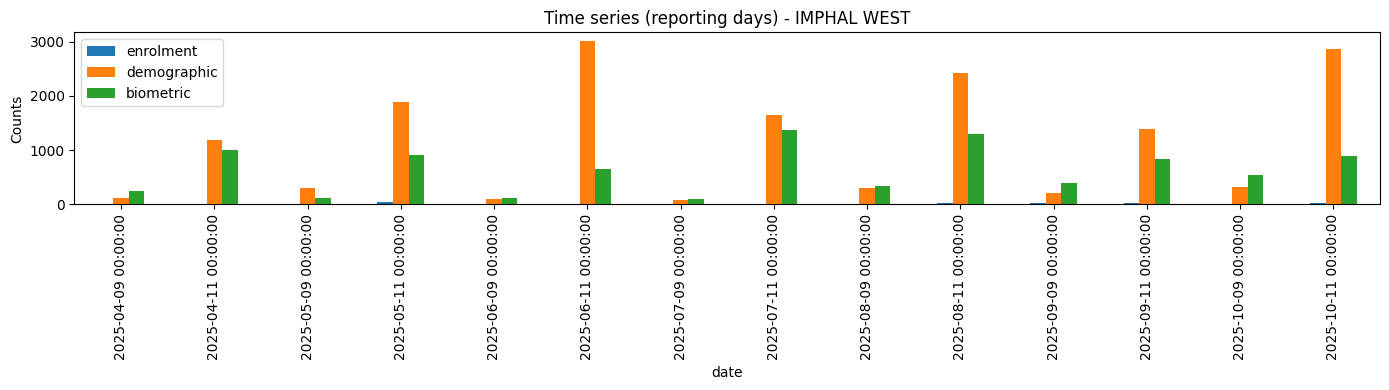

In [64]:
# Plot time series (bars) for district
plt.figure(figsize=(14,4))
df_sample.plot(kind='bar', figsize=(14,4))
plt.title(f"Time series (reporting days) - {sample_district}")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()


In [65]:
import geopandas as gpd

shapefile_path = SHAPE_DIR / "2011_Dist.shp"

if not shapefile_path.exists():
    raise FileNotFoundError(f"Shapefile not found at {shapefile_path}")

gdf = gpd.read_file(shapefile_path)

print("Shapefile loaded successfully")
print("Shape:", gdf.shape)
print("Columns:", gdf.columns.tolist())


Shapefile loaded successfully
Shape: (641, 6)
Columns: ['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode', 'geometry']


In [66]:
print("Columns in shapefile:")
for col in gdf.columns:
    print(col)


Columns in shapefile:
DISTRICT
ST_NM
ST_CEN_CD
DT_CEN_CD
censuscode
geometry


In [67]:
# Normalize district names in shapefile
gdf["district_norm"] = (
    gdf["DISTRICT"]
    .astype(str)
    .str.upper()
    .str.strip()
    .str.replace(r"[^\w\s]", "", regex=True)
)

print("Sample normalized shapefile districts:")
display(gdf[["DISTRICT", "district_norm"]].head(10))


Sample normalized shapefile districts:


,DISTRICT,district_norm
0,Adilabad,ADILABAD
1,Agra,AGRA
2,Ahmadabad,AHMADABAD
3,Ahmadnagar,AHMADNAGAR
4,Aizawl,AIZAWL
5,Ajmer,AJMER
6,Akola,AKOLA
7,Alappuzha,ALAPPUZHA
8,Aligarh,ALIGARH
9,Alirajpur,ALIRAJPUR


In [68]:
# Normalize district names in stress data
geo_filtered["district_norm"] = (
    geo_filtered["district"]
    .astype(str)
    .str.upper()
    .str.strip()
    .str.replace(r"[^\w\s]", "", regex=True)
)

print("Sample normalized stress districts:")
display(geo_filtered[["district", "district_norm"]].head(10))


Sample normalized stress districts:


,district,district_norm
4,ADILABAD,ADILABAD
5,AGAR MALWA,AGAR MALWA
6,AGRA,AGRA
7,AHMADABAD,AHMADABAD
8,AHMADNAGAR,AHMADNAGAR
10,AHMEDABAD,AHMEDABAD
11,AIZAWL,AIZAWL
12,AJMER,AJMER
13,AKOLA,AKOLA
14,ALAPPUZHA,ALAPPUZHA


In [69]:
# Merge geometry with stress data
map_df = gdf.merge(
    geo_filtered,
    on="district_norm",
    how="left"
)

print("Merged GeoDataFrame shape:", map_df.shape)
map_df.head()


Merged GeoDataFrame shape: (664, 24)


,DISTRICT,ST_NM,ST_CEN_CD,DT_CEN_CD,censuscode,geometry,district_norm,district,age_0_5,age_5_17,...,demographic_total,bio_age_5_17,bio_age_17_,biometric_total,demo_to_enrol_ratio,bio_to_enrol_ratio,demo_mad_score,bio_mad_score,demo_spatial_anomaly,bio_spatial_anomaly
0,Adilabad,Andhra Pradesh,28,1,532,"POLYGON ((78.84972 19.7601, 78.85102 19.75945,...",ADILABAD,ADILABAD,737.0,125.0,...,9084.0,4447.0,5720.0,10167.0,10.513889,11.767361,1.688415,3.235363,False,False
1,Agra,Uttar Pradesh,9,15,146,"POLYGON ((78.19803 27.4028, 78.19804 27.40278,...",AGRA,AGRA,1803.0,1292.0,...,22026.0,6773.0,4296.0,11069.0,7.014650,3.525159,0.183846,-0.863877,False,False
2,Ahmadabad,Gujarat,24,7,474,"MULTIPOLYGON (((72.03456 23.50527, 72.03337 23...",AHMADABAD,AHMADABAD,140.0,42.0,...,1333.0,84.0,1237.0,1321.0,7.324176,7.258242,0.316933,0.992763,False,False
3,Ahmadnagar,Maharashtra,27,26,522,"POLYGON ((74.67333 19.9467, 74.67393 19.93509,...",AHMADNAGAR,AHMADNAGAR,1242.0,432.0,...,40638.0,13008.0,15178.0,28186.0,23.862595,16.550793,7.427961,5.614392,True,True
4,Aizawl,Mizoram,15,3,283,"POLYGON ((92.98749 24.40453, 92.99107 24.40236...",AIZAWL,AIZAWL,149.0,40.0,...,1194.0,570.0,372.0,942.0,6.251309,4.931937,-0.144367,-0.164219,False,False


In [70]:
print("Columns currently in geo_filtered:")
for c in geo_filtered.columns:
    print(c)


Columns currently in geo_filtered:
district
age_0_5
age_5_17
age_18_greater
enrolment_total
demo_age_5_17
demo_age_17_
demographic_total
bio_age_5_17
bio_age_17_
biometric_total
demo_to_enrol_ratio
bio_to_enrol_ratio
demo_mad_score
bio_mad_score
demo_spatial_anomaly
bio_spatial_anomaly
district_norm


In [71]:
# Normalize components (z-score style but robust enough for interpretation)
geo_filtered["demo_norm"] = (
    geo_filtered["demo_to_enrol_ratio"] /
    geo_filtered["demo_to_enrol_ratio"].median()
)

geo_filtered["bio_norm"] = (
    geo_filtered["bio_to_enrol_ratio"] /
    geo_filtered["bio_to_enrol_ratio"].median()
)

geo_filtered["enrol_norm"] = (
    geo_filtered["enrolment_total"] /
    geo_filtered["enrolment_total"].median()
)

# Escalation risk: weighted but simple
geo_filtered["escalation_risk"] = (
    0.4 * geo_filtered["demo_norm"] +
    0.4 * geo_filtered["bio_norm"] +
    0.2 * geo_filtered["enrol_norm"]
)

# Sanity check
geo_filtered[[
    "district",
    "demo_norm",
    "bio_norm",
    "enrol_norm",
    "escalation_risk"
]].sort_values("escalation_risk", ascending=False).head(10)


,district,demo_norm,bio_norm,enrol_norm,escalation_risk
375,IMPHAL WEST,11.625762,8.108256,0.272727,7.948152
916,THOUBAL,11.495103,6.263989,0.276680,7.158973
374,IMPHAL EAST,8.200690,5.253298,0.284585,5.438512
136,BISHNUPUR,8.807993,3.846162,0.209486,5.103559
999,YAVATMAL,5.369620,5.612025,1.267457,4.646149
163,CHANDRAPUR,5.309309,5.149427,0.774704,4.338435
287,GADCHIROLI,2.880754,6.639311,0.542819,3.916590
772,RATNAGIRI,2.982628,6.293906,0.552042,3.821022
649,NANDED,5.072622,3.562546,1.824769,3.819021
971,WASHIM,3.562782,5.544452,0.540184,3.750930


In [72]:
assert "escalation_risk" in geo_filtered.columns
print("Escalation risk successfully created.")


Escalation risk successfully created.


In [73]:
map_df = gdf.merge(
    geo_filtered,
    on="district_norm",
    how="left"
)

print("Merged GeoDataFrame shape:", map_df.shape)


Merged GeoDataFrame shape: (664, 28)


In [74]:
# Normalize components (z-score style but robust enough for interpretation)
geo_filtered["demo_norm"] = (
    geo_filtered["demo_to_enrol_ratio"] /
    geo_filtered["demo_to_enrol_ratio"].median()
)

geo_filtered["bio_norm"] = (
    geo_filtered["bio_to_enrol_ratio"] /
    geo_filtered["bio_to_enrol_ratio"].median()
)

geo_filtered["enrol_norm"] = (
    geo_filtered["enrolment_total"] /
    geo_filtered["enrolment_total"].median()
)

geo_filtered["escalation_risk"] = (
    0.4 * geo_filtered["demo_norm"] +
    0.4 * geo_filtered["bio_norm"] +
    0.2 * geo_filtered["enrol_norm"]
)


In [75]:
map_df = gdf.merge(
    geo_filtered,
    on="district_norm",
    how="left"
)

print("Merged GeoDataFrame shape:", map_df.shape)


Merged GeoDataFrame shape: (664, 28)


In [76]:
total_shapes = map_df.shape[0]
matched = map_df["escalation_risk"].notna().sum()
unmatched = total_shapes - matched

print(f"Total districts in shapefile: {total_shapes}")
print(f"Matched with stress data:     {matched}")
print(f"Unmatched (no data):          {unmatched}")
print(f"Match percentage:             {matched / total_shapes * 100:.2f}%")


Total districts in shapefile: 664
Matched with stress data:     563
Unmatched (no data):          101
Match percentage:             84.79%


In [77]:
# Inspect districts with no stress data
unmatched_districts = map_df.loc[
    map_df["escalation_risk"].isna(),
    ["DISTRICT", "ST_NM"]
]

print("Number of unmatched districts:", unmatched_districts.shape[0])
display(unmatched_districts.head(20))


Number of unmatched districts: 101


,DISTRICT,ST_NM
21,Anjaw,Arunanchal Pradesh
22,Anugul,Odisha
26,Ashoknagar,Madhya Pradesh
43,Banas Kantha,Gujarat
64,Bauda,Odisha
80,Bid,Maharashtra
99,Central,NCT of Delhi
103,Champhai,Mizoram
104,Chamrajnagar,Karnataka
114,Chikkaballapura,Karnataka


correction of names

In [78]:
# Controlled alias mapping for known district name differences
district_aliases = {
    # Odisha
    "ANUGUL": "ANGUL",
    "BAUDA": "BOUDH",

    # Maharashtra
    "BID": "BEED",

    # Karnataka
    "CHAMRAJNAGAR": "CHAMARAJANAGAR",
    "CHIKMAGALUR": "CHIKKAMAGALURU",

    # Rajasthan
    "CHITTAURGARH": "CHITTORGARH",
    "DHAULPUR": "DHOLPUR",

    # Andhra Pradesh
    "YSR": "YSR KADAPA",
    "Y S R": "YSR KADAPA",

    # Gujarat
    "BANAS KANTHA": "BANASKANTHA",

    # Delhi
    "CENTRAL": "CENTRAL DELHI",

    # UTs / admin variants
    "DADRA NAGAR HAVELI": "DADRA AND NAGAR HAVELI",
    "DADRA & NAGAR HAVELI": "DADRA AND NAGAR HAVELI",
}

print("Alias mapping size:", len(district_aliases))


Alias mapping size: 13


In [79]:
# Apply alias mapping to stress data
geo_filtered["district_norm_corrected"] = geo_filtered["district_norm"].replace(district_aliases)

# For districts not in alias dict, value stays the same
geo_filtered[["district_norm", "district_norm_corrected"]].head(10)


,district_norm,district_norm_corrected
4,ADILABAD,ADILABAD
5,AGAR MALWA,AGAR MALWA
6,AGRA,AGRA
7,AHMADABAD,AHMADABAD
8,AHMADNAGAR,AHMADNAGAR
10,AHMEDABAD,AHMEDABAD
11,AIZAWL,AIZAWL
12,AJMER,AJMER
13,AKOLA,AKOLA
14,ALAPPUZHA,ALAPPUZHA


In [80]:
map_df = gdf.merge(
    geo_filtered,
    left_on="district_norm",
    right_on="district_norm_corrected",
    how="left"
)

print("Re-merged GeoDataFrame shape:", map_df.shape)


Re-merged GeoDataFrame shape: (664, 30)


In [81]:
total_shapes = map_df.shape[0]
matched = map_df["escalation_risk"].notna().sum()
unmatched = total_shapes - matched

print(f"Total districts in shapefile: {total_shapes}")
print(f"Matched with stress data:     {matched}")
print(f"Unmatched (no data):          {unmatched}")
print(f"Match percentage:             {matched / total_shapes * 100:.2f}%")


Total districts in shapefile: 664
Matched with stress data:     563
Unmatched (no data):          101
Match percentage:             84.79%


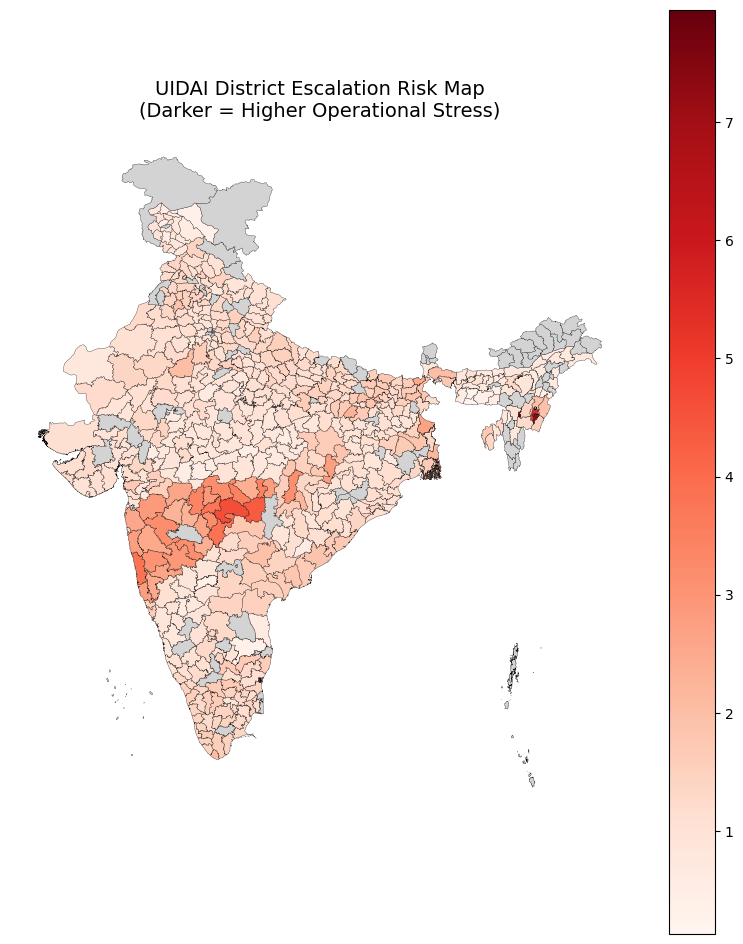

In [82]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

map_df.plot(
    column="escalation_risk",
    cmap="Reds",
    linewidth=0.2,
    edgecolor="black",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "No UIDAI data"
    }
)

ax.set_title(
    "UIDAI District Escalation Risk Map\n(Darker = Higher Operational Stress)",
    fontsize=14
)
ax.axis("off")

plt.savefig(
    "uidai_district_escalation_risk.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()


### Interpretation: Geographic Escalation Risk

This map visualizes district-level Aadhaar operational stress by combining:
- demographic update intensity,
- biometric update intensity,
- and enrolment scale.

Dark red districts represent **high escalation risk**, where UIDAI resources
should be prioritized. Grey districts indicate areas with no common reporting
data in the analysis window, primarily due to administrative restructuring,
low population, or missing snapshots.

Notably, clusters of high stress are observed in parts of:
- Manipur (demographic-led stress),
- Maharashtra (biometric-led stress),
indicating region-specific operational challenges rather than random noise.
